In [ ]:
import os
import numpy as np
from PIL import Image
#from utils.labels import trainId2label
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, callbacks


In [ ]:
import os

# Set base directory dynamically
CITYSCAPES_DIR = os.path.abspath("../data")  # Ensures the path is absolute

# Define image and label paths
IMAGES_DIR = os.path.join(CITYSCAPES_DIR, "leftImg8bit_trainvaltest", "leftImg8bit", "train")
LABELS_DIR = os.path.join(CITYSCAPES_DIR, "gtFine_trainvaltest", "gtFine", "train")
VAL_IMAGES_DIR = os.path.join(CITYSCAPES_DIR, "leftImg8bit_trainvaltest", "leftImg8bit", "val")
VAL_LABELS_DIR = os.path.join(CITYSCAPES_DIR, "gtFine_trainvaltest", "gtFine", "val")

# Constants
LIMIT_IMAGES = 2975  # Number of images to sample
MAX_PIXELS = 100000  # Max number of pixels to process
LABEL_ID = 7  # Road label
PATCH_SIZE = 16 # Patch size

In [ ]:
def get_city_folders(directory):
    """Retrieve all city subfolders."""
    return [os.path.join(directory, city) for city in os.listdir(directory) if os.path.isdir(os.path.join(directory, city))]


In [ ]:
def load_images_from_folder(images_dir, labels_dir):
    image_paths = []
    label_paths = []
    
    for filename in os.listdir(images_dir):
        if filename.endswith(".png"): 
            image_paths.append(os.path.join(images_dir, filename))
            label_paths.append(os.path.join(labels_dir, filename.replace("leftImg8bit", "gtFine").replace(".png", "_label.png")))
    
    return image_paths, label_paths

In [ ]:
def get_image_label_pairs(images_dir, labels_dir):
    """Match RGB images with their corresponding label IDs."""
    image_label_pairs = []
    for city_folder in get_city_folders(images_dir):
        city_name = os.path.basename(city_folder)
        label_city_folder = os.path.join(labels_dir, city_name)

        for image_file in os.listdir(city_folder):
            if image_file.endswith("_leftImg8bit.png"):
                # Image path
                image_path = os.path.join(city_folder, image_file)
                # Corresponding label file
                label_file = image_file.replace("_leftImg8bit.png", "_gtFine_labelIds.png")
                label_path = os.path.join(label_city_folder, label_file)
                if os.path.exists(label_path):
                    image_label_pairs.append((image_path, label_path))
                    if len(image_label_pairs) >= LIMIT_IMAGES:  # Stop if limit is reached
                        return image_label_pairs
    return image_label_pairs


In [ ]:
# Preprocess data and extract patches
def preprocess_data_with_patches(image_label_pairs, patch_size=PATCH_SIZE, max_pixels=MAX_PIXELS, label_Id=LABEL_ID, target_width=512):
    """Extract pixel patches and labels for training, keeping the aspect ratio."""
    X = [] 
    y = []  
    total_pixels = 0
    pixels_per_image = max_pixels // LIMIT_IMAGES // 2
    if patch_size % 2 == 0:
        half_patch_size = patch_size // 2
        odd = 0
    else:
        half_patch_size = patch_size // 2
        odd = 1  # Half the size of the patch (for padding)
    
    for image_path, label_path in tqdm.tqdm(image_label_pairs):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        h, w = image.shape[:2]
        
        target_height = int((target_width / w) * h)
        image = cv2.resize(image, (target_width, target_height))

        label_img = cv2.imread(label_path, cv2.IMREAD_UNCHANGED)
        label_img = cv2.resize(label_img, (target_width, target_height))

        padded_image = cv2.copyMakeBorder(
            image, half_patch_size, half_patch_size, half_patch_size, half_patch_size, cv2.BORDER_REFLECT
        )
        label_pixels = label_img.flatten()
        
        road_mask = (label_pixels == label_Id)
        not_road_mask = ~road_mask

        road_indices = np.where(road_mask)[0]
        not_road_indices = np.where(not_road_mask)[0]
        
        sampled_road_indices = np.random.choice(
            road_indices, min(pixels_per_image, len(road_indices)), replace=False
        )
        sampled_not_road_indices = np.random.choice(
            not_road_indices, min(pixels_per_image, len(not_road_indices)), replace=False
        )

        sampled_indices = np.concatenate([sampled_road_indices, sampled_not_road_indices])
        sampled_labels = np.concatenate([
            [1] * len(sampled_road_indices), 
            [0] * len(sampled_not_road_indices)
        ])

        for idx, label in zip(sampled_indices, sampled_labels):
            row, col = divmod(idx, label_img.shape[1])
            row += half_patch_size  
            col += half_patch_size 
            patch = padded_image[row - half_patch_size : row + half_patch_size + odd,
                                 col - half_patch_size : col + half_patch_size + odd, :]
            X.append(patch)
            y.append(label)
            
            total_pixels += 1
            if total_pixels >= max_pixels:
                break
        if total_pixels >= max_pixels:
            break

    return np.array(X), np.array(y)

NameError: name 'MAX_PIXELS' is not defined

In [ ]:
def extract_train_val_data(patch_size=PATCH_SIZE, max_pixels=MAX_PIXELS, label_Id=LABEL_ID, target_width=256):
    """Extract training and validation data."""
    train_image_label_pairs = get_image_label_pairs(IMAGES_DIR, LABELS_DIR)
    val_image_label_pairs = get_image_label_pairs(VAL_IMAGES_DIR, VAL_LABELS_DIR)
    
    X_train, y_train = preprocess_data_with_patches(train_image_label_pairs, patch_size, max_pixels, label_Id, target_width)
    X_val, y_val = preprocess_data_with_patches(val_image_label_pairs, patch_size, max_pixels, label_Id, target_width)

    return X_train, X_val, y_train, y_val

X_train, X_val, y_train, y_val = extract_train_val_data()

100%|██████████| 500/500 [00:20<00:00, 24.02it/s]


In [ ]:
print(f"Processed {len(X_train)} pixels")
print(f"Number of road pixels: {np.sum(y_train)}")
print(f"Number of not road pixels: {len(y_train) - np.sum(y_train)}")

print(f"\nProcessed {len(X_val)} pixels")
print(f"Number of road pixels: {np.sum(y_val)}")
print(f"Number of not road pixels: {len(y_val) - np.sum(y_val)}")

Processed 94899 pixels
Number of road pixels: 47299.0
Number of not road pixels: 47600.0

Processed 15811 pixels
Number of road pixels: 7811.0
Number of not road pixels: 8000.0


In [ ]:
X_train, X_val = X_train / 255.0, X_val / 255.0

In [ ]:
def build_patch_classifier(patch_size):
    model = models.Sequential([
        layers.Input(shape=(patch_size, patch_size, 3)),  # Patch input (H x W x Channels)
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Output: road (1) or not road (0)
    ])
    return model


In [ ]:
def train_patch_classifier(X_train, y_train, X_val, y_val, patch_size, epochs=20, batch_size=32):
    model = build_patch_classifier(patch_size)

    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    checkpoint_cb = callbacks.ModelCheckpoint(
        "patch_classifier_best.keras", save_best_only=True, monitor="val_accuracy", mode="max"
    )
    early_stopping_cb = callbacks.EarlyStopping(
        patience=5, restore_best_weights=True, monitor="val_accuracy", mode="max"
    )
    reduce_lr_cb = callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, mode="min"
    )

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb],
        verbose=1 
    )

    return model, history

patch_size = 16
epochs = 20
batch_size = 32

model = build_patch_classifier(patch_size)
model, training_history = train_patch_classifier(X_train, y_train, X_val, y_val, patch_size, epochs, batch_size)
model.summary()

Epoch 1/20
2966/2966 [==============================] - 19s 6ms/step - loss: 0.3679 - accuracy: 0.8447 - val_loss: 0.3437 - val_accuracy: 0.8565 - lr: 0.0010
Epoch 2/20
2966/2966 [==============================] - 19s 6ms/step - loss: 0.3275 - accuracy: 0.8649 - val_loss: 0.3206 - val_accuracy: 0.8702 - lr: 0.0010
Epoch 3/20
2966/2966 [==============================] - 20s 7ms/step - loss: 0.3106 - accuracy: 0.8726 - val_loss: 0.3248 - val_accuracy: 0.8703 - lr: 0.0010
Epoch 4/20
2966/2966 [==============================] - 20s 7ms/step - loss: 0.2957 - accuracy: 0.8786 - val_loss: 0.3059 - val_accuracy: 0.8770 - lr: 0.0010
Epoch 5/20
2966/2966 [==============================] - 21s 7ms/step - loss: 0.2832 - accuracy: 0.8836 - val_loss: 0.3048 - val_accuracy: 0.8827 - lr: 0.0010
Epoch 6/20
2966/2966 [==============================] - 21s 7ms/step - loss: 0.2732 - accuracy: 0.8881 - val_loss: 0.2974 - val_accuracy: 0.8798 - lr: 0.0010
Epoch 7/20
2966/2966 [==============================

In [ ]:
model.save("road_patch_classifier_32.keras")

495/495 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

         0.0       0.91      0.87      0.89      8000
         1.0       0.88      0.91      0.89      7811

    accuracy                           0.89     15811
   macro avg       0.89      0.89      0.89     15811
weighted avg       0.89      0.89      0.89     15811



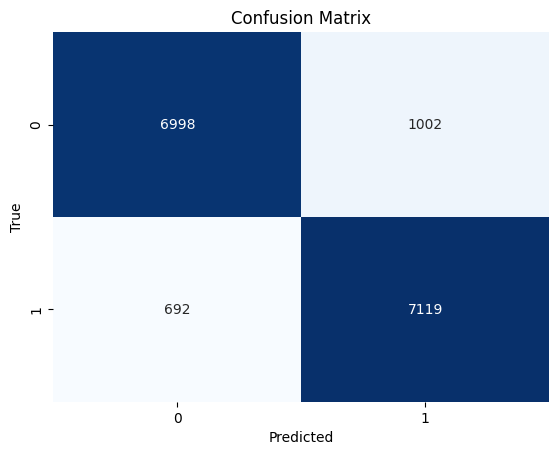

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = model.predict(X_val)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_val, y_pred)

print(classification_report(y_val, y_pred))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

495/495 [==============================] - 1s 2ms/step


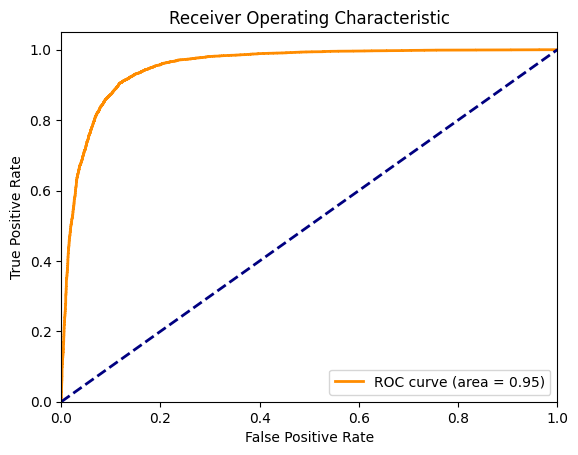

In [ ]:
# plot roc curve
from sklearn.metrics import roc_curve, auc
y_pred = model.predict(X_val)

fpr, tpr, threshold = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


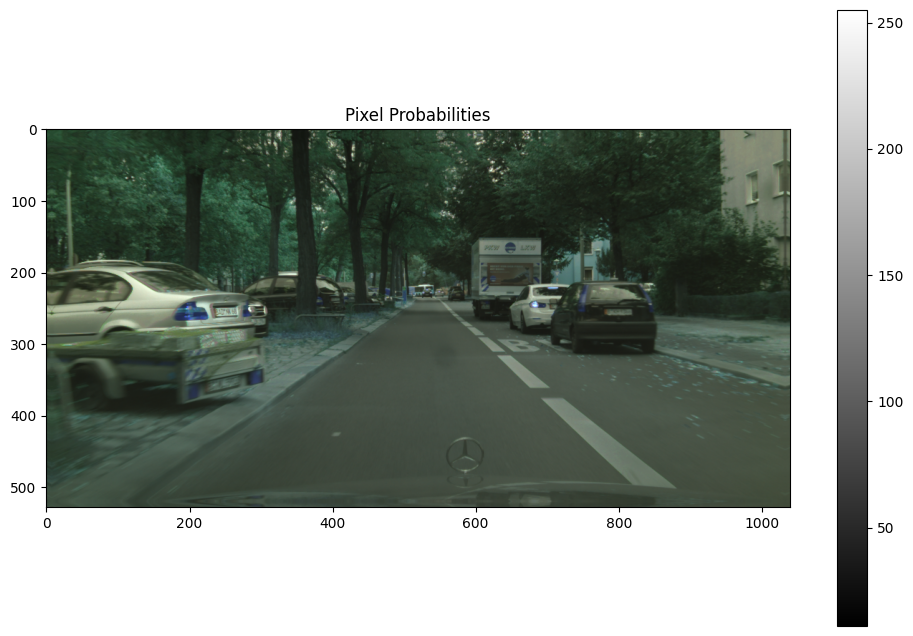

16384/16384 [==============================] - 22s 1ms/step


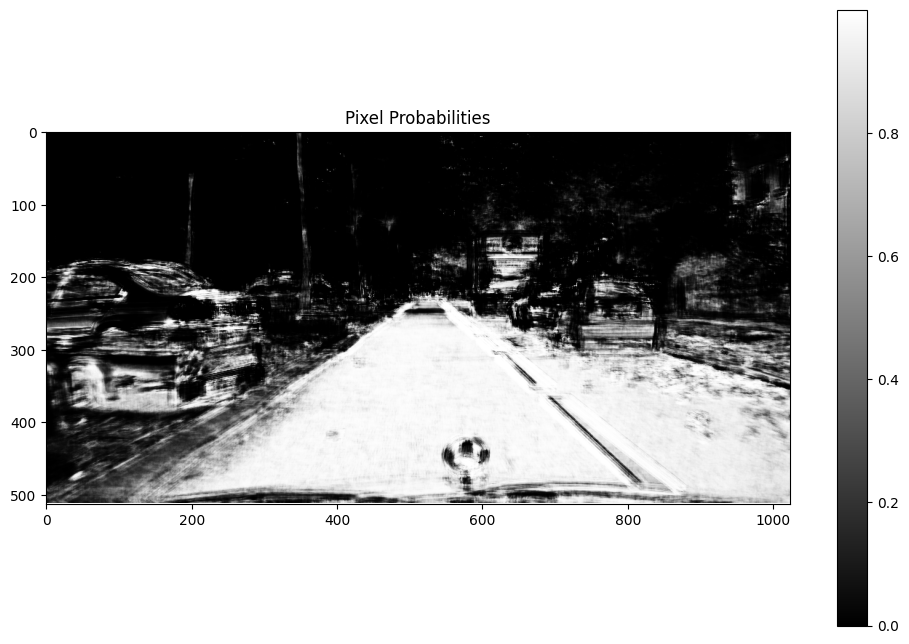

In [ ]:
def classify_image_with_patches(image_path, model, patch_size=PATCH_SIZE, target_width=512):
    """Classify all pixels in an image using a patch-based model in batch."""
    # Load and resize the image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    h, w = image.shape[:2]
    target_height = int((target_width / w) * h)
    image = cv2.resize(image, (target_width, target_height))

    # Pad the image for patch extraction
    if patch_size % 2 == 0:
        half_patch_size = patch_size // 2
        odd = 0
    else:
        half_patch_size = patch_size // 2
        odd = 1

    padded_image = cv2.copyMakeBorder(
        image, half_patch_size, half_patch_size, half_patch_size, half_patch_size, cv2.BORDER_REFLECT
    )
    plt.figure(figsize=(12, 8))
    plt.imshow(padded_image, cmap='gray')
    plt.colorbar()
    plt.title('Pixel Probabilities')
    plt.show()

    # Extract all patches
    patches = []
    for row in range(target_height):
        for col in range(target_width):
            # Extract patch centered at the current pixel
            patch = padded_image[row:row + patch_size, col:col + patch_size+odd, :]
            patches.append(patch)

    # Normalize patches and reshape for model input
    patches = np.array(patches) / 255.0  # Normalize
    patches = patches.reshape(-1, patch_size, patch_size, 3)

    # Predict labels for all patches in one batch
    predictions = model.predict(patches)

    # Reshape predictions to match the image dimensions
    pixel_labels = predictions.reshape(target_height, target_width)

    return pixel_labels


def plot_pixel_probabilities(image_path, pixel_labels):
    """Plot pixel probabilities as a grayscale image."""
    plt.figure(figsize=(12, 8))
    plt.imshow(pixel_labels, cmap='gray')
    plt.colorbar()
    plt.title('Pixel Probabilities')
    plt.show()


# Classify an image using the patch-based model
image_path = r"..\data\leftImg8bit_trainvaltest\leftImg8bit\test\berlin\berlin_000529_000019_leftImg8bit.png"
pixel_labels = classify_image_with_patches(image_path, model, patch_size=PATCH_SIZE, target_width=1024)
plot_pixel_probabilities(image_path, pixel_labels)


In [ ]:
import gc
gc.collect()

18715